# Experimentation Only

In [1]:
import sys
!{sys.executable} -m pip install tqdm

You are using pip version 9.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from datetime import datetime
import datetime as dt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#For Prediction
from sklearn import metrics
from sklearn import preprocessing, cross_validation

import keras
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Read Datasets 
research_data_raw = pd.read_csv('Datasets/bitcoin_research_data_v2.csv')
# Drop unnecessary columns
research_data = research_data_raw.drop('Unnamed: 0', axis=1)
research_data.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized
0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0
1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0
2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0
3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0
4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0


In [4]:
# Convert data to milliseconds
research_data['Epoch'] = pd.to_datetime(research_data['Date'] + ' 23:59:59.000')
research_data['Epoch'] = (research_data['Epoch'] - dt.datetime(1970,1,1)).dt.total_seconds().astype('int64')
research_data.head()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized,Epoch
0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0,1557619199
1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0,1557532799
2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0,1557446399
3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0,1557359999
4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0,1557273599


In [5]:
research_data_imp2 = research_data.copy()
research_data_imp2.sort_values(by='Date', inplace=True, ascending=True) # Sort by date ascending
forecast_out = int(math.ceil(0.0001 * len(research_data_imp2))) # 0.01% of data
#forecast_out = int(math.ceil(0.0025 * len(research_data_imp2))) # 0.05% of data
print(len(research_data_imp2))
print(forecast_out)

1808
1


In [6]:
research_data_imp2['Prediction'] = research_data_imp2['Close'].shift(-forecast_out)
research_data_imp2.tail()

,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USD,Popularity,Popularity_Normalized,Epoch,Prediction
4,2019-05-07,BTCUSD,5687.4,5955.8,5687.4,5906.7,3668.12,21496575.65,12.0,1200.0,1557273599,5939.6
3,2019-05-08,BTCUSD,5744.0,5983.2,5660.0,5939.6,6007.11,35184697.52,12.0,1200.0,1557359999,6151.4
2,2019-05-09,BTCUSD,5939.6,6174.0,5933.2,6151.4,7405.18,44816872.39,12.0,1200.0,1557446399,6337.9
1,2019-05-10,BTCUSD,6151.4,6430.0,6110.1,6337.9,9872.86,62166515.28,12.0,1200.0,1557532799,6793.5
0,2019-05-11,BTCUSD,6337.9,6984.8,6337.9,6793.5,9855.87,66133073.75,12.0,1200.0,1557619199,NaN


In [7]:
def load_data_with_test():
    X = np.array(research_data_imp2.drop(['Prediction', 'Symbol', 'Date', 'Popularity'], 1)) # Create X with numeric columns only
    # X = np.array(research_data_imp2['Close'])
    # X = research_data_imp2['Close'].to_frame()
    X = preprocessing.scale(X)
    X_forecast = X[-forecast_out:]
    X = X[:-forecast_out]

    # research_data_imp2.dropna(inplace=True)

    y = np.array(research_data_imp2['Prediction'])
    y = y[:-forecast_out]

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
    
    return [X_train, X_test, y_train, y_test]

In [41]:
def load_data_with_test2():
    X = np.array(research_data_imp2.drop(['Prediction', 'Symbol', 'Date', 'Popularity'], 1)) # Create X with numeric columns only
    # X = np.array(research_data_imp2['Close'])
    # X = research_data_imp2['Close'].to_frame()
    X = preprocessing.scale(X)
    X_forecast = X[-forecast_out:]
    X = X[:-forecast_out]

    # research_data_imp2.dropna(inplace=True)

    y = np.array(research_data_imp2.drop(['Prediction', 'Symbol', 'Date', 'Popularity'], 1)) # Create X with numeric columns only
    y = y[:-forecast_out]

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
    
    return [X_train, X_test, y_train, y_test]

In [8]:
def load_data():
    X = np.array(research_data_imp2.drop(['Prediction', 'Symbol', 'Date', 'Popularity'], 1)) # Create X with numeric columns only
    X = preprocessing.scale(X)
    return X
    

In [9]:
# X_train, X_test, y_train, y_test = load_data()
# print(X_train.shape)
# print(y_train.shape)
X_train = load_data()
print(X_train.shape)

(1808, 8)


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [10]:
def adam_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [11]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=128,input_dim=8))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=256))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=8, activation='tanh'))
    
    #generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(), metrics=['accuracy'])
    generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return generator
g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1152      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 4104      
Total para

In [12]:
def create_discriminator():
    optimizer = RMSprop(lr=0.0002, decay=6e-8)

    discriminator=Sequential()
    discriminator.add(Dense(units=512,input_dim=8))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return discriminator
d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               4608      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
__________

In [13]:
def create_gan(discriminator, generator):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    discriminator.trainable=False
    gan_input = Input(shape=(8,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 8)                 169864    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 168961    
Total params: 338,825
Trainable params: 169,864
Non-trainable params: 168,961
_________________________________________________________________


In [14]:
def create_gan2(d, g):
    optimizer = RMSprop(lr=0.0001, decay=3e-8)
    AM = Sequential()
    AM.add(g)
    AM.add(d)
    AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
        metrics=['accuracy'])
    return AM
gan2 = create_gan2(d,g)
gan2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 8)                 169864    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 168961    
Total params: 338,825
Trainable params: 169,864
Non-trainable params: 168,961
_________________________________________________________________


In [22]:
adversarial_loss = []
discrimator_loss = []
gen_samples = []

generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

def training(epochs=1, batch_size=128):
    global adversarial_loss
    global discrimator_loss
    global gen_samples
    
    global generator
    global discriminator
    global gan
    
    #Loading the data
    #(X_train, y_train, X_test, y_test) = load_data()
    X_train = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    # generator = create_generator()
    # discriminator = create_discriminator()
    # gan = create_gan(discriminator, generator)
    #gan = create_gan2(discriminator, generator)
    
    for e in range(1, epochs+1 ):
        print("Epoch %d" %e)
        for i in tqdm(range(batch_size)):
            #generate  random noise as an input  to  initialize the  generator
            noise = np.random.normal(0,1, [batch_size, 8])
            
            # Generate fake prices from noised input
            generated_prices = generator.predict(noise)
            
            # Get a random set of real prices
            prices_batch = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of real and fake data 
            X = np.concatenate([prices_batch, generated_prices])
            
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise = np.random.normal(0,1, [batch_size, 8])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            a_loss = gan.train_on_batch(noise, y_gen)
            
            if i == (batch_size-1):
                log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
                log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
                print(log_mesg)
                
            discrimator_loss.append(d_loss)
            adversarial_loss.append(a_loss)
            
        if e == 1 or e % 5 == 0:
            # generate synthetic dataset
            gen_samples_set = []
            for batch_idx in range(int(len(X_train) / batch_size)):
            # for batch_idx in range(int(len(X_train) / 100)):
                # noise= np.random.normal(loc=0, scale=1, size=[100, 100])
                noise= np.random.normal(0,1, [batch_size, 8])
                generated_data = generator.predict(noise)
                gen_samples_set.append(generated_data)

            gen_samples = np.vstack(gen_samples_set)

In [23]:
#training(400,128)
training(1,128)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


100%|██████████| 128/128 [00:06<00:00, 20.77it/s]


1: [D loss: 0.624293, acc: 0.441406]  [A loss: 0.915241, acc: 0.125000]


In [24]:
def get_2D_array_values(arr, idx):
    arr_map = []
    for i in range(len(arr)):
        arr_map.append(arr[i][idx])
    
    return arr_map

Text(0,0.5,'Loss')

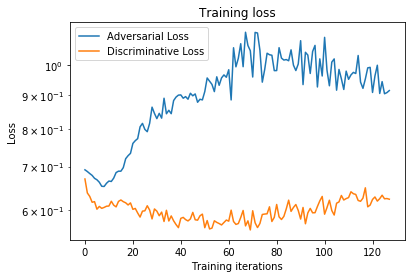

In [25]:
adversarial_loss_map = get_2D_array_values(adversarial_loss, 0)
discrimator_loss_map = get_2D_array_values(discrimator_loss, 0)

ax = pd.DataFrame(
    {
        'Adversarial Loss': adversarial_loss_map,
        'Discriminative Loss': discrimator_loss_map,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Training iterations")
ax.set_ylabel("Loss")

Text(0,0.5,'Accuracy')

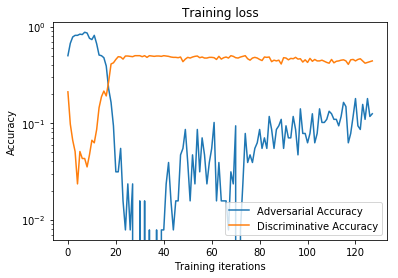

In [26]:
adversarial_acc_map = get_2D_array_values(adversarial_loss, 1)
discrimator_acc_map = get_2D_array_values(discrimator_loss, 1)

ax_acc = pd.DataFrame(
    {
        'Adversarial Accuracy': adversarial_acc_map,
        'Discriminative Accuracy': discrimator_acc_map,
    }
).plot(title='Training loss', logy=True)
ax_acc.set_xlabel("Training iterations")
ax_acc.set_ylabel("Accuracy")

In [27]:
print(gen_samples.shape)
print(len(gen_samples))
print(X_train.shape)
print(len(X_train))

(1792, 8)
1792
(1808, 8)
1808


In [45]:
(X_train2, X_test2, y_train2, y_test2) = load_data_with_test2()

prediction_gan = generator.predict(X_test2)

# print("The Explained Variance: %.2f" % prediction_gan.score(X_test2, y_test2))  
print("The Explained Variance: %.2f" % metrics.explained_variance_score(y_test2, prediction_gan))  
print("The Mean Absolute Error: %.2f" % metrics.mean_absolute_error(y_test2, prediction_gan))  
#print("The Median Absolute Error: %.2f" % metrics.median_absolute_error(y_test2, prediction_gan)) 
print("The Mean Squared Error: %.2f" % metrics.mean_squared_error(y_test2, prediction_gan)) 
print("The Root Mean Squared Error: %.2f" % (np.sqrt(metrics.mean_squared_error(y_test2, prediction_gan))))

generator.predict(X_train)[0]

The Explained Variance: -0.00
The Mean Absolute Error: 186773696.87
The Mean Squared Error: 273974764618681568.00
The Root Mean Squared Error: 523425987.72


/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


array([-0.03044232,  0.09835079,  0.04489816, -0.04864755,  0.6600674 ,
        0.14946795, -0.06927289, -0.6227084 ], dtype=float32)